In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [489]:
from sklearn import model_selection
from sklearn import linear_model

In [490]:
%matplotlib inline
plt.style.use('ggplot')

In [491]:
houses = pd.read_csv('../train.csv')

In [492]:
MSSubClass = \
'''
20:1-STORY 1946 & NEWER ALL STYLES
30:1-STORY 1945 & OLDER
40:1-STORY W/FINISHED ATTIC ALL AGES
45:1-1/2 STORY - UNFINISHED ALL AGES
50:1-1/2 STORY FINISHED ALL AGES
60:2-STORY 1946 & NEWER
70:2-STORY 1945 & OLDER
75:2-1/2 STORY ALL AGES
80:SPLIT OR MULTI-LEVEL
85:SPLIT FOYER
90:DUPLEX - ALL STYLES AND AGES
120:1-STORY PUD (Planned Unit Development) - 1946 & NEWER
150:1-1/2 STORY PUD - ALL AGES
160:2-STORY PUD - 1946 & NEWER
180:PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
190:2 FAMILY CONVERSION - ALL STYLES AND AGES
'''
MSSubClass_split = MSSubClass.strip().split('\n')
MSSubClass_dict = {int(k.split(':')[0]): k.split(':')[1] for k in MSSubClass_split}

In [493]:
houses['MSSubClass'] = houses['MSSubClass'].apply(lambda x: MSSubClass_dict[x])

In [494]:
dtypes = pd.Series([houses[x].dtype for x in houses.columns])

In [495]:
is_numeric = dtypes.apply(lambda x: True if x == int or x == float else False)

In [497]:
num_cols = houses.columns[is_numeric]



In [498]:
cat_cols = houses.columns[~is_numeric]

In [499]:
hdummy = houses.copy()

for col in cat_cols:
    for value in houses[col].unique():
        hdummy['{}XXX{}'.format(col,value)] = hdummy[col] == value
    hdummy.drop(col, axis=1, inplace=True)

In [500]:
for col in num_cols:
    hdummy["%sXXXis_null" % col] = hdummy[col].isnull()
    hdummy[col].fillna(-1, inplace=True)

In [501]:
hdummy.to_csv('../data/train_withdummy_pandas.csv')

In [502]:
y = hdummy['SalePrice']
X = hdummy.drop('SalePrice', axis=1)

In [503]:
#Xtr, Xte, ytr, yte = model_selection.train_test_split(X,y, test_size=.2)

In [504]:
model = linear_model.Lasso(alpha=.1, max_iter=10000)

In [419]:
model.fit(Xtr, ytr)

/Users/travis/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [437]:
coeffs = []
for alp in np.arange(.1,100, .1):
    model = linear_model.Lasso(alpha=alp, max_iter=500)
    model.fit(X,y)
    row = {k:v for k,v in zip(hdummy.columns, model.coef_)}
    row['alpha'] = alp
    coeffs.append(row)

/Users/travis/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [438]:
codf = pd.DataFrame(coeffs)

In [439]:
codf = codf.set_index('alpha')

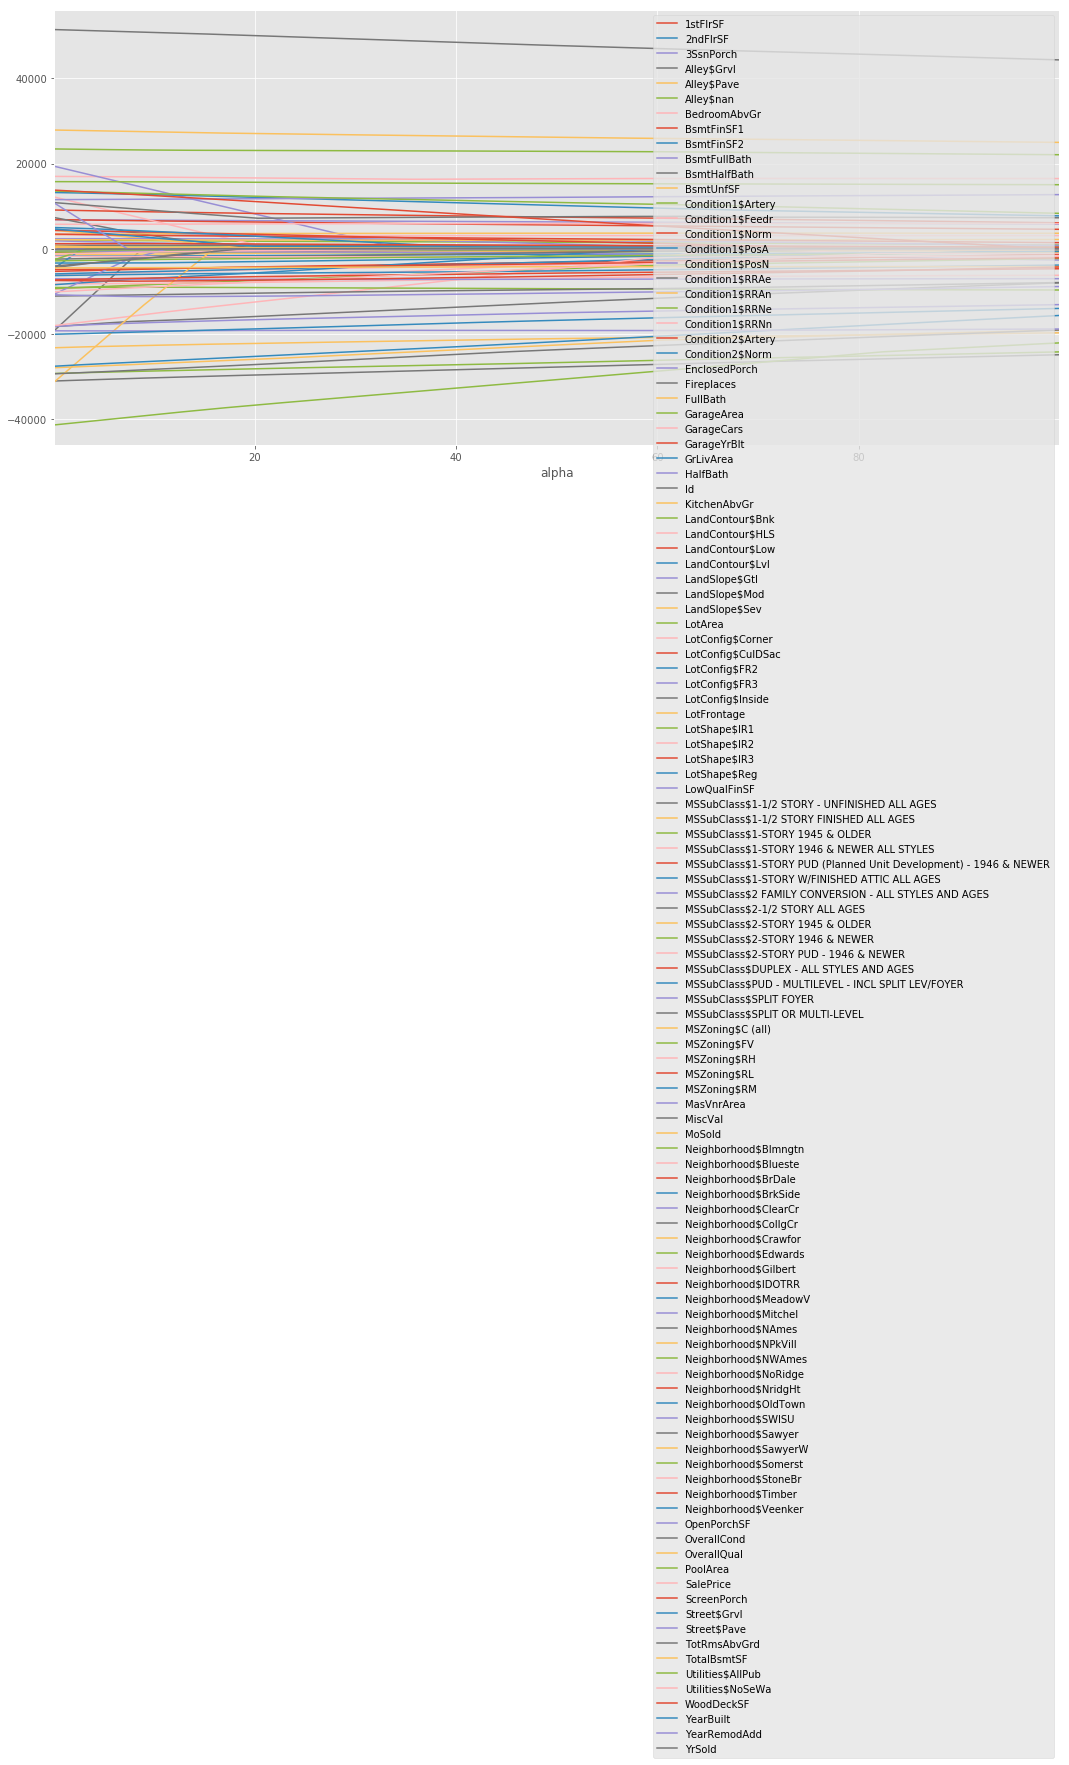

In [440]:
codf.plot(figsize=(18,8))
#this is unreadable too many damn terms

In [441]:
## Convert coefficents to binary
codfs = codf.T
for col in codfs.columns:
    codfs[col] = codfs[col] != 0

In [442]:
Xtr, Xte, ytr, yte = model_selection.train_test_split(X, y)

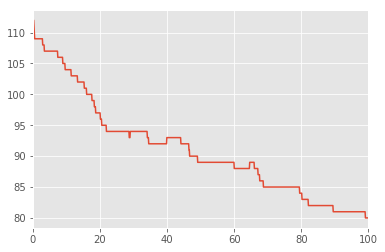

In [443]:
#Generate plot of regularization parameter verses number of terms remaining
rem_terms = {}
for col in codfs.columns:
    rem_terms[col] = codfs[col].sum()
rem_terms = pd.Series(rem_terms)
rem_terms.plot()

In [ ]:
#Find the columns not eliminated by Lasso for each value of Alpha
keepcols = {}
lasso_cols = codfs
# lasso_cols = codfs.drop('alpha')
for val in np.arange(1,100):
    keepcols[val] = lasso_cols[lasso_cols[val] > 0].index
keepcols = pd.Series(keepcols)

In [ ]:
new_idx = rem_terms[(rem_terms.index < 100) & (rem_terms.index.astype(int) == rem_terms.index)]
keepcols.index = new_idx.values[1:]

In [ ]:
train_error = {}
test_error = {}
test_score = {}
train_score = {}
train_predictions = {}
test_predictions = {}
for key, value in keepcols.iteritems():
    y = hdummy['SalePrice']
    X = hdummy[value]
#     X = hdummy.drop('SalePrice', axis=1)
    Xtr, Xte, ytr, yte = model_selection.train_test_split(X, y, train_size=.80)
    model = linear_model.LinearRegression(n_jobs=-1)
#     print(Xtr.shape[1])
    model.fit(Xtr, ytr)
    train_predictions[key] = model.predict(Xtr)
#     train_error[key] = np.sqrt(((train_predictions[key] - ytr) ** 2).sum())
    train_score[key] = model.score(Xtr, ytr)
    test_predictions = model.predict(Xte)
    test_score[key] = model.score(Xte, yte)
#     test_error[key] = np.sqrt(((test_predictions[key] - yte) ** 2).sum())

In [ ]:
test_score = pd.Series(test_score)
train_score = pd.Series(test_score)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train_score)
# ax.plot(test_score)
# ax.plot(train_error)
# ax.plot(np.arange(test_error.size), test_error.sort_values())
# ax.plot(np.arange(test_error.size), test_error.sort_values().index)

In [ ]:
ncolls = ['1stFlrSF', '2ndFlrSF', 'Alley$Grvl', 'BedroomAbvGr', 'BldgType$1Fam',
       'BsmtCond$Fa', 'BsmtExposure$Av', 'BsmtExposure$Gd', 'BsmtExposure$No',
       'BsmtFinSF1', 'BsmtFinType1$BLQ', 'BsmtFinType1$GLQ',
       'BsmtFinType1$Rec', 'BsmtFullBath', 'BsmtQual$Ex', 'BsmtQual$Fa',
       'BsmtQual$Gd', 'BsmtQual$TA', 'BsmtUnfSF', 'CentralAir$Y',
       'Electrical$FuseA', 'Electrical$FuseF', 'EnclosedPorch', 'ExterCond$Fa',
       'ExterQual$Ex', 'ExterQual$Gd', 'Exterior1st$CemntBd',
       'Exterior1st$MetalSd', 'Exterior1st$VinylSd', 'Exterior2nd$Wd Sdng',
       'Fence$MnPrv', 'FireplaceQu$Ex', 'FireplaceQu$Gd', 'FireplaceQu$TA',
       'Fireplaces', 'Foundation$BrkTil', 'Foundation$PConc', 'FullBath',
       'GarageArea', 'GarageCond$Fa', 'GarageFinish$Fin', 'GarageFinish$RFn',
       'GarageFinish$Unf', 'GarageQual$Fa', 'GarageQual$TA',
       'GarageType$Attchd', 'GarageType$BuiltIn', 'GarageType$Detchd',
       'GarageYrBlt', 'HalfBath', 'HeatingQC$Ex', 'HeatingQC$Fa',
       'HeatingQC$Gd', 'HeatingQC$TA', 'KitchenAbvGr', 'KitchenQual$Ex',
       'KitchenQual$Fa', 'KitchenQual$Gd', 'LandContour$HLS', 'LotArea',
       'LotConfig$CulDSac', 'LotFrontage', 'LotShape$IR2', 'LotShape$Reg',
       'MSSubClass$1-1/2 STORY FINISHED ALL AGES',
       'MSSubClass$1-STORY 1945 & OLDER', 'MSSubClass$2-STORY 1946 & NEWER',
       'MSZoning$RM', 'MasVnrArea', 'MasVnrType$None', 'MasVnrType$Stone',
       'Neighborhood$BrkSide', 'Neighborhood$Edwards', 'Neighborhood$IDOTRR',
       'Neighborhood$NAmes', 'Neighborhood$NoRidge', 'Neighborhood$NridgHt',
       'Neighborhood$OldTown', 'Neighborhood$Sawyer', 'Neighborhood$Somerst',
       'Neighborhood$StoneBr', 'Neighborhood$Timber', 'OpenPorchSF',
       'PavedDrive$Y', 'PoolQC$Ex', 'RoofMatl$WdShngl', 'RoofStyle$Gable',
       'SaleCondition$Normal', 'SaleCondition$Partial', 'SaleType$WD',
       'TotRmsAbvGrd', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd']

In [ ]:
for col in ncol

Id


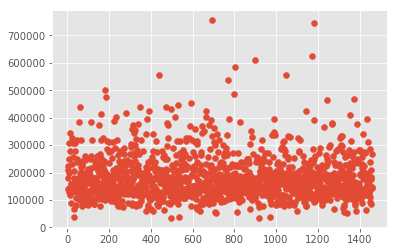

hello?
LotFrontage


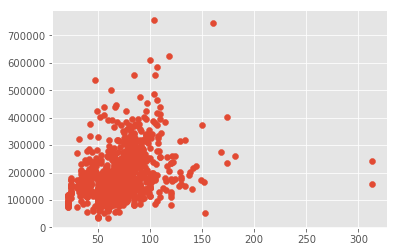

hello?
LotArea


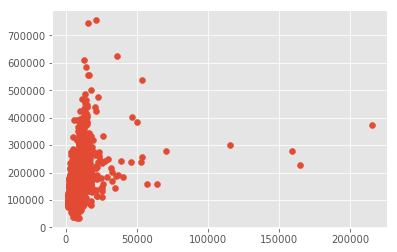

hello?
OverallQual


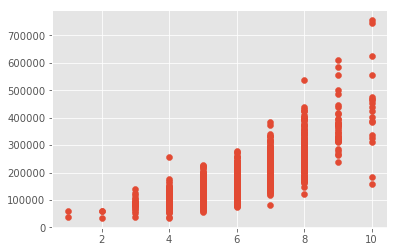

hello?
OverallCond


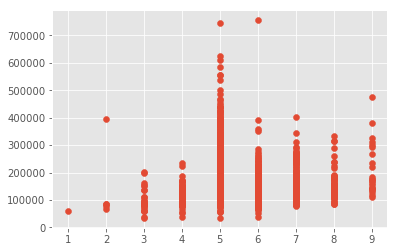

hello?
YearBuilt


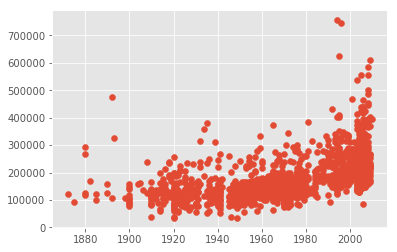

hello?
YearRemodAdd


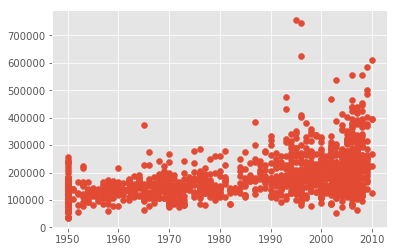

In [ ]:
i=0

while True:
    col = num_cols[i]
    print(col)
    plt.scatter(houses[col], houses['SalePrice'])
    plt.show()
    i = i+1
    if input('hello?') == 'x':
        break

In [ ]:
has_nulls = LotArea

In [ ]:
YearBuilt = log

In [ ]:
OverallQual = sqrt

In [ ]:
OverallCond = bad

In [521]:
cats = houses[cat_cols]

In [527]:
cats[cats.columns[0]].value_counts()

1-STORY 1946 & NEWER ALL STYLES                          536
2-STORY 1946 & NEWER                                     299
1-1/2 STORY FINISHED ALL AGES                            144
1-STORY PUD (Planned Unit Development) - 1946 & NEWER     87
1-STORY 1945 & OLDER                                      69
2-STORY PUD - 1946 & NEWER                                63
2-STORY 1945 & OLDER                                      60
SPLIT OR MULTI-LEVEL                                      58
DUPLEX - ALL STYLES AND AGES                              52
2 FAMILY CONVERSION - ALL STYLES AND AGES                 30
SPLIT FOYER                                               20
2-1/2 STORY ALL AGES                                      16
1-1/2 STORY - UNFINISHED ALL AGES                         12
PUD - MULTILEVEL - INCL SPLIT LEV/FOYER                   10
1-STORY W/FINISHED ATTIC ALL AGES                          4
Name: MSSubClass, dtype: int64

In [528]:
cats.columns[0]

'MSSubClass'